In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#  pip install --upgrade scipy networkx

# 1. Data

In [2]:
df_hero_net = pd.read_csv(r"hero-network.csv")
df_edges = pd.read_csv(r"edges.csv")
df_nodes = pd.read_csv(r"nodes.csv")

In [3]:
df_hero_net

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE /
574464,CALLISTO,CALIBAN/
574465,CALIBAN/,ROGUE /


In [4]:
df_edges

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
...,...,...
96099,ZZZAX,H2 326
96100,ZZZAX,H2 327
96101,ZZZAX,M/CP 8/4
96102,ZZZAX,PM 47


In [5]:
df_nodes

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero
...,...,...
19085,"ZOTA, CARLO",hero
19086,ZOTA,hero
19087,ZURAS,hero
19088,ZURI,hero


In [6]:
df_nodes.shape

(19090, 2)

In [7]:
n_comics = df_nodes[df_nodes.type == 'comic'].count()
n_heros = df_nodes[df_nodes.type == 'hero'].count()
print(n_comics, n_heros)

node    12651
type    12651
dtype: int64 node    6439
type    6439
dtype: int64


## 1.1 Pre-processing 

In [8]:
df_hero_net["hero1"] = df_hero_net["hero1"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)
df_hero_net["hero2"] = df_hero_net["hero2"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

In [9]:
df_hero_net

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE
574464,CALLISTO,CALIBAN
574465,CALIBAN,ROGUE


In [10]:
df_edges["hero"] = df_edges["hero"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

In [11]:
hero = set(df_edges.hero)
hero_union = set(df_hero_net.hero1).union(set(df_hero_net.hero2))

diff = hero_union - hero.intersection(hero_union)
diff

{'SPIDER-MAN/PETER PAR'}

In [12]:
def jaccard_similarity(setA, setB):
    ''' 
    This function simply computes the Jaccard similarity from its definition.
    '''
    return len(set(setA).intersection(setB))/len(set(setA).union(setB))

In [13]:
for hero in set(df_edges.hero):
    for elem in diff:
        sim = jaccard_similarity(set(elem), set(hero))
        if sim >= 0.5:
            df_hero_net = df_hero_net.replace(elem, hero)

df_hero_net

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE
574464,CALLISTO,CALIBAN
574465,CALIBAN,ROGUE


In [14]:
# test
hero = set(df_edges.hero)
hero_union = set(df_hero_net.hero1).union(set(df_hero_net.hero2))

diff = hero_union - hero.intersection(hero_union)
diff

set()

In [15]:
print(len(hero_union), len(hero.intersection(hero_union))) # all heroes' names in 'hero-network.csv' are now found in 'edges.csv'

6420 6420


## 1.2 First graph

In [16]:
G1 = nx.MultiGraph()

In [17]:
df_hero_net.apply(lambda row: G1.add_edge(row['hero1'], row['hero2']), axis=1)

0          0
1          0
2          0
3          1
4          1
          ..
574462    27
574463    22
574464     8
574465    11
574466     1
Length: 574467, dtype: int64

In [18]:
#drop sefl-loops
G1.remove_edges_from(nx.selfloop_edges(G1))

In [19]:
list(G1.edges())[:10]

[('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', 'PRINCESS ZANDA'),
 ('LITTLE, ABNER', "BLACK PANTHER/T'CHAL"),
 ('LITTLE, ABNER', "BLACK PANTHER/T'CHAL")]

In [118]:
dicOfOccurances = {}
for h1,h2 in df_hero_net.to_numpy():
    if h1 != h2:
        if (h1,h2) in dicOfOccurances:
            dicOfOccurances[(h1,h2)] += 1
        else:
            dicOfOccurances[(h1,h2)] = 1

In [119]:
G1_weighted = nx.MultiGraph()

In [120]:
i = 0
for edge in list(G1.edges()):
    try:
        G1_weighted.add_edge(edge[0], edge[1], weight = 1/dicOfOccurances[edge])
    except:
        G1_weighted.add_edge(edge[0], edge[1], weight = 1/dicOfOccurances[(edge[1], edge[0])])


In [121]:
edges, weights = zip(*nx.get_edge_attributes(G1_weighted, 'weight').items())
for i in range(20):
    print((edges[i], weights[i]))

(('LITTLE, ABNER', 'PRINCESS ZANDA', 0), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 1), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 2), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 3), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 4), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 5), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 6), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 7), 0.2)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 0), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 1), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 2), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 3), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 4), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 5), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 6), 0.25)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 0), 0.3333333333333333)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 1), 0.3333333333333333)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 2), 0.3333333333333333)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 3), 0.33333333333

In [122]:
G1_weighted2 = nx.Graph(G1_weighted)

In [123]:
edges, weights = zip(*nx.get_edge_attributes(G1_weighted2, 'weight').items())
for i in range(20):
    print((edges[i], weights[i]))

(('LITTLE, ABNER', 'PRINCESS ZANDA'), 0.2)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL"), 0.25)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR'), 0.3333333333333333)
(('LITTLE, ABNER', 'IRON MAN/TONY STARK'), 1.0)
(('LITTLE, ABNER', 'GOLDEN-BLADE'), 1.0)
(('LITTLE, ABNER', 'DIXON, GENERAL'), 1.0)
(('LITTLE, ABNER', 'IRON MAN IV/JAMES R.'), 1.0)
(('LITTLE, ABNER', 'JOCASTA'), 1.0)
(('LITTLE, ABNER', 'FUJIKAWA, RUMIKO'), 1.0)
(('LITTLE, ABNER', 'MADAME MENACE/SUNSET'), 1.0)
(('LITTLE, ABNER', 'JACOBS, GLENDA'), 1.0)
(('LITTLE, ABNER', 'WAR MACHINE II/PARNE'), 1.0)
(('LITTLE, ABNER', 'SAPPER'), 1.0)
(('LITTLE, ABNER', 'HOGAN, VIRGINIA PEPP'), 1.0)
(('LITTLE, ABNER', 'BINARY/CAROL DANVERS'), 1.0)
(('LITTLE, ABNER', 'FIN FANG FOOM/MIDGAR'), 1.0)
(('LITTLE, ABNER', 'MANN, DR. J. VERNON'), 0.5)
(('LITTLE, ABNER', 'THOR/DR. DONALD BLAK'), 1.0)
(('LITTLE, ABNER', 'TEMPEST II/NICOLETTE'), 1.0)
(('LITTLE, ABNER', 'JARVIS, EDWIN'), 1.0)


In [124]:
dicOfWeights = {}
for edge in G1_weighted2.edges():
    dicOfWeights[edge] = G1_weighted2.get_edge_data(edge[0], edge[1])['weight']

In [ ]:
fig = plt.figure(figsize=(18,18))
nx.draw(G1_weighted2, with_labels=True,node_size=300)
plt.show()

## 1.3 Second graph

In [138]:
attributes = {}
for elem,type in df_nodes.to_numpy():
    attributes[elem] = {'type' : type } 

In [139]:
G2 = nx.from_pandas_edgelist(df_edges, 'hero', 'comic')
nx.set_node_attributes(G2, attributes)

In [142]:
edges, types = zip(*nx.get_node_attributes(G2, 'type').items())
for i in range(10):
    print(edges[i], types[i])

24-HOUR MAN/EMMANUEL hero
AA2 35 comic
3-D MAN/CHARLES CHAN hero
AVF 4 comic
AVF 5 comic
COC 1 comic
H2 251 comic
H2 252 comic
M/PRM 35 comic
M/PRM 36 comic


In [ ]:
fig = plt.figure(figsize=(18,18))
nx.draw(G2, with_labels=True,node_size=300)
plt.show()

In [132]:
topN_heroes = df_edges.groupby('hero').count().sort_values(by='comic', ascending=False).head(10)
topN_heroes
# this are the top N heroes ( in this case the top 10) of the heroes that apperar in the most comics the G2 graph

,comic
hero,
SPIDER-MAN/PETER PARKER,1577
CAPTAIN AMERICA,1334
IRON MAN/TONY STARK,1150
THING/BENJAMIN J. GR,963
THOR/DR. DONALD BLAK,956
HUMAN TORCH/JOHNNY S,886
MR. FANTASTIC/REED R,854
HULK/DR. ROBERT BRUC,835
WOLVERINE/LOGAN,819


# 2. Backend Implementation

## Functionality 1 - extract the graph's features

The number of nodes in the network (if type 2, report for both node types)

In [144]:
n_nodesG1 = int(G1_weighted2.number_of_nodes())
print("Total number of nodes of G1: ", n_nodesG1)
# the total number of nodes in G1 is 6420

Total number of nodes of G1:  6420


In [145]:
count_hero = 0
count_comic = 0
for elements in types:
    if elements == 'hero':
        count_hero += 1
    elif elements == 'comic':
        count_comic += 1
print("the number of heros in G2 is:", count_hero)
print("the number of comics in G2 is:", count_comic)
# the total number of nodes in G2 of heroes  is 6007 and comics is 12651.

the number of heros in G2 is: 6007
the number of comics in G2 is: 12651


The number of collaborations of each superhero with the others

In [ ]:
degree_G1 = G1_weighted2.degree()
#print("collaborations of each node:", degree_G1)
# we can see for each hero the collaboration that one has with other heros
# sorting it by the number of collaborations 
sorted_degree_G1 = sorted(degree_G1, key=lambda x: x[1], reverse=True)
print("sorted collaborations of each node:", sorted_degree_G1)


#len(G1_weighted.edges(hero))
# we can see for each hero the collaboration that one has with other heros

The number of heroes that have appeared in each comic (only if type 2)

In [147]:
#number of heroes that have appeared in each comic of G2
hero_appeard = df_edges.groupby('comic').count().sort_values(by='hero', ascending=False)
hero_appeard

,hero
comic,
COC 1,111
IW 3,91
IW 1,90
H2 279,87
IW 4,80
...,...
MYSTIC COMICS 10,1
N 2/4,1
N 37,1


In [36]:
edges, types = zip(*nx.get_node_attributes(G2, 'type').items())
for i in range(len(types)):
#count the number of heroes that have appeared in each comic
    if types[i] == 'comic':
        print(edges[i], types[i], df_edges.groupby('comic').count().sort_values(by='hero', ascending=False).loc[edges[i]].values[0])

AA2 35 comic 6
AVF 4 comic 11
AVF 5 comic 11
COC 1 comic 111
H2 251 comic 8
H2 252 comic 8
M/PRM 35 comic 1
M/PRM 36 comic 1
M/PRM 37 comic 1
WI? 9 comic 5
CA3 36 comic 4
CM 51 comic 11
Q 14 comic 27
Q 16 comic 18
T 208 comic 12
T 214 comic 11
T 215 comic 11
T 216 comic 13
T 440 comic 20
SLEEP 1 comic 9
SLEEP 19 comic 11
SLEEP 2 comic 4
DD/SM 1 comic 9
W2 52 comic 11
W2 53 comic 14
XFOR 108 comic 11
XFOR 109 comic 11
ABOM 2 comic 13
ABOM 3 comic 18
ASM 23 comic 20
H 15 comic 7
H 20 comic 3
H2 136 comic 6
H2 137 comic 2
H2 159 comic 5
H2 171 comic 7
H2 194 comic 7
H2 195 comic 7
H2 196 comic 6
H2 270 comic 8
H2 278 comic 53
H2 287 comic 5
H2 288 comic 4
H2 289 comic 5
H2 290 comic 3
H2 364 comic 4
H2 366 comic 11
H2 382 comic 12
H2 383 comic 11
H2 384 comic 5
H2 431 comic 4
H2 432 comic 6
H2 459 comic 5
H2 472 comic 6
H2 473 comic 6
H2 474 comic 7
H3 24 comic 7
H3 25 comic 6
M/SH3 6 comic 9
M/SH3 7 comic 10
M/SH3 8 comic 9
N 58 comic 18
N 59 comic 6
SOLOA 12 comic 3
SS 12 comic 2
SWII 7

KeyboardInterrupt: 

In [148]:
print("The most popular hero is:", max(G2.degree(), key=lambda x: x[1])[0])
# the most popular hero that apperas in a comic is Spiderman

The most popular hero is: SPIDER-MAN/PETER PARKER


The network's density

In [149]:
# calculate the density from scratch without nx of G1
densityG1 = len(G1_weighted2.edges())/(n_nodesG1*(n_nodesG1-1)/2)
print("The density of G1 is:", densityG1)
# density of G2
densityG2 = len(G2.edges())/(count_hero*(count_hero-1)/2)
print("The density of G2 is:", densityG2)

The density of G1 is: 0.00810958898791021
The density of G2 is: 0.005327561844958216


In [150]:
#check the density of G1 and G2 with nx
densityG1 = nx.density(G1_weighted2)
# network density of G1
print("Network density of G1: ", densityG1)
densityG2 = nx.density(G2)
print("Network density of G2: ", densityG2)
# network density of G2

Network density of G1:  0.00810958898791021
Network density of G2:  0.0005276171051089377


The network's degree distribution

In [ ]:

def plot_degree_dist(G1_weighted2):
    degree_G1 = [G1_weighted2.degree(n) for n in G1_weighted2.nodes()]
    plt.hist(degree_G1, bins=50)
    plt.show()
plot_degree_dist(nx.gnp_random_graph(200, 0.8, directed=True))
#network's degree distribution of G1

In [ ]:
def plot_degree_dist(G2):
    degree_G2 = [G2.degree(n) for n in G2.nodes()]
    plt.hist(degree_G2, bins=50)
    plt.show()
plot_degree_dist(nx.gnp_random_graph(100, 0.5, directed=False))
# network's degree distribution of G2

In [ ]:
degree_G2 = list(G2.degree())
print("Degree for all nodes:", degree_G2)
sorted_degreeG2 = sorted((i for x, i in degree_G2), reverse=True)

The average degree of the network

In [154]:
degree_sequence = [deg for i, deg in G1_weighted2.degree()]
avg_degreeG1 = sum(degree_sequence) / len(degree_sequence)
print("Average degree of G1: ", avg_degreeG1)

Average degree of G1:  52.05545171339564


In [157]:
# average degree of G2
degree_sequence = [deg for i, deg in G2.degree()]
avg_degreeG2 = sum(degree_sequence) / len(degree_sequence)
print("Average degree of G2: ", avg_degreeG2)

Average degree of G2:  10.070100068109184


The network's Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)


In [ ]:
def hubs(G1_weighted2):
    degrees = [G1_weighted2.degree(n) for n in G1_weighted2.nodes()]
    t = np.percentile(degrees,95)
    ex_nodes = [n for n in G1_weighted2.nodes() if G1_weighted2.degree(n) > t]
    return(ex_nodes)
print("Nodes with degrees more extensive than the 95th percentile of the degree distribution: ", len(hubs(G1_weighted)))
print("that are:", hubs(G1_weighted2))
#hubs in G1 are 319

In [ ]:
def hubs(G2):
    degrees = [G2.degree(n) for n in G2.nodes()]
    t = np.percentile(degrees,95)
    ex_nodes = [n for n in G2.nodes() if G2.degree(n) > t]
    return(ex_nodes)
print("Nodes with degrees more extensive than the 95th percentile of the degree distribution: ", len(hubs(G2)))
print("that are:", hubs(G2))
#hubs in G1 are 927

Whether the Network is sparse or dense

In [159]:
# density of G1 from scratch
def density_G1(G1_weighted2):
    n = G1_weighted2.number_of_nodes()
    m = G1_weighted2.number_of_edges()
    return 2*m/(n*(n-1))
print("Density of G1: ", density_G1(G1_weighted2))


Density of G1:  0.00810958898791021


In [160]:
type_graphG1 = ""    
if density_G1(G1_weighted2) >= 0.5:
    type_graphG1 = "DENSE"
else:
    type_graphG1 = "SPARSE"
print("The type of G1 is: ", type_graphG1)
# G1 is sparse


The type of G1 is:  SPARSE


In [161]:
# density of G2 from scratch
def density_G2(G2):
    n = G2.number_of_nodes()
    m = G2.number_of_edges()
    return 2*m/(n*(n-1))
print("Density of G2: ", density_G2(G2))

Density of G2:  0.0005276171051089377


In [162]:
type_graphG2 = ""
if density_G2(G2) >= 0.5:
    type_graphG2 = "DENSE"
else:
    type_graphG2 = "SPARSE"
print("The type of G2 is: ", type_graphG2)
#G2 is sparse

The type of G2 is:  SPARSE


# Functionality 2 - Find top superheroes!

The metric's value over the considered graph

In [61]:
from collections import deque
from collections import defaultdict
import random

In [168]:
# calcolo algoritmo BFS per la betweenness centrality
def BFS(G2, s, t):
  queue = deque([s])
  visited = set()
  while queue:
    u = queue.popleft()
    if u not in visited:
      visited.add(u)
      for v in G2[u]:
        queue.append(v)
        if v == t:
          return visited
  return visited

In [238]:
def fun_betweenness_centrality(G2):
  betweenness_G2 = defaultdict(int)
  for i, s in enumerate(G2):
    if i == 10:
      break
    for j, t in enumerate(G2):
      if j == 10:
        break
      if s != t:
        # Calcolo i percorsi minimi tra s e t utilizzando l'algoritmo BFS
        path = BFS(G2, s, t)
        for v in path:
          betweenness_G2[v] += 1
  # Normalizza i valori della betweenness
  n = len(G2)
  for v in betweenness_G2:
    betweenness_G2[v] /= (n-1)*(n-2)
  return betweenness_G2
result = fun_betweenness_centrality(G2)
####### Stampa solo i primi 10 elementi del dizionario
for i, (node, value) in enumerate(result.items()):
  if i == 10:
    break
  print(f"{node}: {value}")

24-HOUR MAN/EMMANUEL: 4.667043379426975e-08
A 64: 7.137831050888316e-08
SLASHER: 4.94157534292268e-08
A 198: 7.137831050888316e-08
A 47: 7.137831050888316e-08
A 19: 7.137831050888316e-08
A 88: 7.137831050888316e-08
A 302: 7.137831050888316e-08
A3 4: 7.137831050888316e-08
WARLORD: 4.94157534292268e-08


In [ ]:
# betwenness centrality of G2 with nx for the first 10 nodes
betweenness = nx.betweenness_centrality(G2, normalized=True)

In [ ]:
# Stampa i valori della betweenness centrality dei primi 10 nodi
for i, (node, value) in enumerate(betweenness.items()):
    if i == 10:
        break
    print(f"{node}: {value}")

In [291]:
def fun_degree_centrality(G2, node):
  num_neighbors = len(list(G2.neighbors(node)))
  fun_degree_centrality = num_neighbors / (len(G2) - 1)
  return fun_degree_centrality
# doing it for the first 10 nodes
for i, node in enumerate(G2.nodes()):
  if i == 10:
    break
  print(f"{node}: {fun_degree_centrality(G2, node)}")

24-HOUR MAN/EMMANUEL: 5.239442523315519e-05
AA2 35: 0.00031436655139893113
3-D MAN/CHARLES CHAN: 0.00047154982709839675
AVF 4: 0.0005763386775647072
AVF 5: 0.0005763386775647072
COC 1: 0.005815781200880226
H2 251: 0.00041915540186524154
H2 252: 0.00041915540186524154
M/PRM 35: 5.239442523315519e-05
M/PRM 36: 5.239442523315519e-05


In [272]:
# Calculate the degree centrality for the graph with networkx to check results:
degree_cen = nx.degree_centrality(G2)
count = 0
for node, value in degree_cen.items():
    # Print the degree centrality for the current node
    print(f"{node}: {value}")
    count += 1
    if count == 10:
        break

24-HOUR MAN/EMMANUEL: 5.239442523315519e-05
AA2 35: 0.00031436655139893113
3-D MAN/CHARLES CHAN: 0.00047154982709839675
AVF 4: 0.0005763386775647072
AVF 5: 0.0005763386775647072
COC 1: 0.005815781200880226
H2 251: 0.00041915540186524154
H2 252: 0.00041915540186524154
M/PRM 35: 5.239442523315519e-05
M/PRM 36: 5.239442523315519e-05


In [278]:
#PageRank centrality
def fun_pagerank_centrality(G2, alpha=0.85, max_iter=100, tol=1e-6):
  # Inizializza i valori di PageRank di ogni nodo con 1/n, dove n è il numero di nodi del grafo
  n = len(G2)
  pagerank = {node: 1/n for node in G2}
  # Itera finché non si raggiunge la convergenza o il numero massimo di iterazioni
  for i in range(max_iter):
    diff = 0
    # Calcola il nuovo valore di PageRank per ogni nodo
    for node in pagerank:
      rank = sum(pagerank[neighbor] / len(G2[neighbor]) for neighbor in G2[node])
      # Aggiorna il valore di PageRank del nodo utilizzando la formula di PageRank
      new_rank = (1 - alpha) / n + alpha * rank
      diff += abs(new_rank - pagerank[node])
      pagerank[node] = new_rank
    # Se la differenza è minore della soglia di tolleranza, interrompi il loop
    if diff < tol:
      break
  return pagerank

#### stampo i risultati per i primi 10 nodi
result = fun_pagerank_centrality(G2)
for i, (node, value) in enumerate(result.items()):
  if i == 10:
    break
  print(f"{node}: {value}")

24-HOUR MAN/EMMANUEL: 1.6190634785391538e-05
AA2 35: 5.881329456000286e-05
3-D MAN/CHARLES CHAN: 8.040458459529586e-05
AVF 4: 7.25368207844207e-05
AVF 5: 7.25912275515007e-05
COC 1: 0.00046164593189993363
H2 251: 4.5732790282748295e-05
H2 252: 4.5732790282748295e-05
M/PRM 35: 1.5452518353066664e-05
M/PRM 36: 1.5452518353066664e-05


In [279]:
#calculate pagerank centrality with networkx
pagerank = nx.pagerank(G2)
count = 0
for node, value in pagerank.items():
    print(f"{node}: {value}")
    count += 1
    if count == 10:
        break

24-HOUR MAN/EMMANUEL: 1.619088825788385e-05
AA2 35: 5.891311954989046e-05
3-D MAN/CHARLES CHAN: 7.99930311037567e-05
AVF 4: 7.307020737907148e-05
AVF 5: 7.312285805701876e-05
COC 1: 0.0004666087517830386
H2 251: 4.609355643115735e-05
H2 252: 4.609355643115735e-05
M/PRM 35: 1.5502849120300773e-05
M/PRM 36: 1.5502849120300773e-05


In [283]:
def fun_closeness_centrality(G2, node):
  # Inizializza una coda e un dizionario per tenere traccia della distanza di ogni nodo dal nodo in questione
  queue = deque([node])
  distances = {node: 0}

  # Esegue la ricerca in larghezza a partire dal nodo in questione
  while queue:
    current_node = queue.popleft()
    for neighbor in G2[current_node]:
      if neighbor not in distances:
        distances[neighbor] = distances[current_node] + 1
        queue.append(neighbor)

  # Calcola la somma delle distanze di tutti i nodi dal nodo in questione
  total_distance = sum(distances.values())
  # Calcola la centralità di prossimità come il numero di nodi del grafo diviso dalla somma delle distanze
  closeness_centrality = len(G2) / total_distance
  return closeness_centrality

In [287]:
# stampo i risultati per i primi 10 nodi
for i, node in enumerate(G2.nodes()):
  if i == 10:
    break
  print(f"{node}: {fun_closeness_centrality(G2, node)}")

24-HOUR MAN/EMMANUEL: 0.14019508468849617
AA2 35: 0.16296682092177386
3-D MAN/CHARLES CHAN: 0.2699106284292098
AVF 4: 0.25798123969399617
AVF 5: 0.25817665359123493
COC 1: 0.36759494646021107
H2 251: 0.24156784326629796
H2 252: 0.24156784326629796
M/PRM 35: 0.21269222197459328
M/PRM 36: 0.21269222197459328


In [ ]:
# calculate the closeness centrality with networkx
closeness = nx.closeness_centrality(G2)
#stampo i risultati per i primi 10 nodi
count = 0
for node, value in closeness.items():
    print(f"{node}: {value}")
    count += 1
    if count == 10:
        break
    

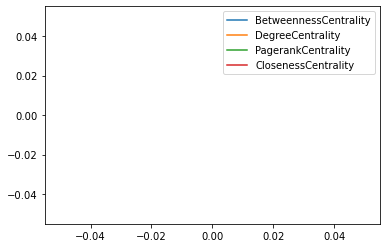

In [301]:
# comparing the results of the different centrality measures:
measures = [fun_betweenness_centrality, fun_degree_centrality, fun_pagerank_centrality, fun_closeness_centrality]

# Create a list of labels for the measures
labels = ['BetweennessCentrality', 'DegreeCentrality', 'PagerankCentrality','ClosenessCentrality']

# Plot the measures
for measure, label in zip(measures, labels):
    # Get the measure values as a dictionary
    measure_values = nx.get_node_attributes(G2, measure)
    # Normalize the measure values by dividing them by the maximum value
    normalized_values = {node: value/max(measure_values.values()) for node, value in measure_values.items()}
    # Plot the normalized measure values
    plt.plot(normalized_values.values(), label=label)
    #plt.bar(normalized_values.keys(), normalized_values.values(), label=label)
# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [108]:
def fun_centrality(G, node, measure):
  
  if measure == "betweenness":
    # Calcola la centralità di intermediazione del nodo
    centrality = fun_betweenness_centrality(G)[node]
  elif measure == "pagerank":
    # Calcola il PageRank del nodo
    centrality = fun_pagerank_centrality(G)[node]
  elif measure == "degree":
    # Calcola la degree centrality del nodo
    centrality = fun_degree_centrality(G)[node]
  elif measure == "closeness":
    # Calcola la centralità di prossimità del nodo
    centrality = fun_closeness_centrality(G)[node]
  else:
    raise ValueError("Misura di centralità non supportata")
  return centrality

## 3. Frontend Implementation

### Visualization 1

A table containing the following general information about the graph:

- Number of nodes in the network
- Density of the network
- Average degree of the network
- Whether the network is sparse or dense

In [93]:
dataG1 = {
    "Number of nodes": n_nodesG1,
    "Density": densityG1,
    "Average degree": avg_degreeG1,
    "netowrk type" : type_graphG1
}
df_G1 = pd.DataFrame(dataG1, index=[0])
df_G1
print(df_G1)

   Number of nodes   Density  Average degree netowrk type
0             6420  0.027772      178.266355       SPARSE


In [53]:
dataG2 = {
    " nodes_hero": count_hero,
    "nodes_comic": count_comic,
    "Density": densityG2,
    "Average degree": avg_degreeG2,
    "netowrk type" : type_graphG2
}
df_G2 = pd.DataFrame(dataG2, index=[0])
df_G2
print(df_G2)

    nodes_hero  nodes_comic   Density  Average degree netowrk type
0         6007        12651  0.000528         10.0701       SPARSE


A table that lists the network's hubs

In [54]:
# visualization of a table that lists the network's hubs
df_hubs = pd.DataFrame(hubs(G1_weighted), columns=['Hubs'])
df_hubs


,Hubs
0,BLACK PANTHER/T'CHAL
1,IRON MAN/TONY STARK
2,IRON MAN IV/JAMES R.
3,JOCASTA
4,"HOGAN, VIRGINIA PEPP"
...,...
314,LIGHTSPEED/JULIE POW
315,PATRIOT/JEFF MACE
316,DIAMOND LIL/LILLIAN
317,"STACY, GWEN"


A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1)



In [ ]:
# A plot depicting the number of collaborations of each hero in descending order of G1
plt.figure(figsize=(10,10))
plt.bar(*zip(*sorted_degree_G1))
plt.title("Number of collaborations of each hero in descending order of G1")
plt.xlabel("Hero")
plt.ylabel("Number of collaborations")
plt.show()

A plot depicting the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)


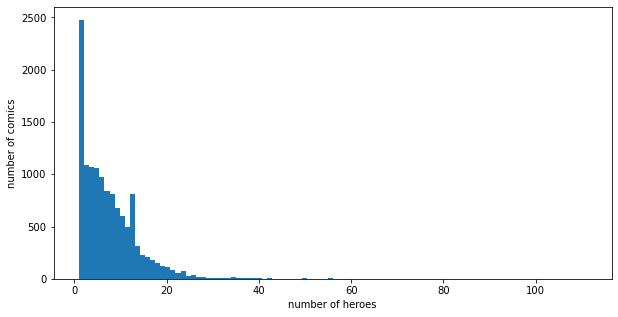

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(hero_appeard['hero'], bins=100)
plt.xlabel('number of heroes')
plt.ylabel('number of comics')
plt.show()
# plot the distribution of the number of heroes that have appeared in each comic of G2

A plot depicting the degree distribution of the network


In [ ]:
plt.figure(figsize=(10,5))
plt.hist(degree_G1, bins=50)
plt.xlabel('degree')
plt.ylabel('number of nodes')
plt.show()
#plot depicting the degree distribution of the network G1

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(*zip(*sorted_degree_G1[:50]))
plt.xlabel('degree')
plt.ylabel('number of nodes')
plt.show()
# with the first 50 heroes of G1 and depicting the degree distribution of the networ

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(sorted_degreeG2, bins=50)
plt.xlim(10, 400)
plt.xlabel('degree')
plt.ylabel('number of nodes')
plt.show()

In [ ]:
plt.xscale()
plt.xlabel('degree')
plt.ylabel('number of nodes')
plt.show()
#plot depicting the degree distribution of the network G2

### Visualization 2 - Visualize centrality measure

A table containing the information related to the requested centrality measure for:
- The average of the requested centrality measure for all of the network's nodes

In [307]:
#A table containing the information related to the requested centrality measure for the average of the requested centrality measure for all of the network's nodes
def fun_centrality_table(G2, measure):
    if measure == "betweenness":
        # Calcola la centralità di intermediazione del nodo
        centrality = fun_betweenness_centrality(G2)
    elif measure == "pagerank":
        # Calcola il PageRank del nodo
        centrality = fun_pagerank_centrality(G2)
    elif measure == "degree":
        # Calcola la degree centrality del nodo
        centrality = fun_degree_centrality(G2)
    elif measure == "closeness":
        # Calcola la centralità di prossimità del nodo
        centrality = fun_closeness_centrality(G2)
    else:
        raise ValueError("Misura di centralità non supportata")
    df_centrality = pd.DataFrame(centrality, index=[0])
    return df_centrality


In [308]:
betweenness_centrality_dict = dict( fun_betweenness_centrality(G2))
# average of betweennes centrality of G2 from scratch
def avg_betweenness_centrality(G2):
    return sum(betweenness_centrality_dict.values())/len(betweenness_centrality_dict)
print("Average of betweenness centrality of G2: ", avg_betweenness_centrality(G2))
#create a table of average betweenness centrality for all nodes of G2
data_betweenness_G2 = {node: avg_betweenness_centrality(G2) for node in G2.nodes()}
df_betweenness_G2 = pd.DataFrame.from_dict(data_betweenness_G2, orient='index', columns=['Average betweenness centrality'])

Average of betweenness centrality of G2:  3.4147992016459226e-08


In [309]:
pagereank_centrality_dict = dict( fun_pagerank_centrality(G2))
# average of pagerank centrality of G2 from scratch
def avg_pagerank_centrality(G2):
    return sum(pagereank_centrality_dict.values())/len(pagereank_centrality_dict)
print("Average of pagerank centrality of G2: ", avg_pagerank_centrality(G2))
#create a table of average pagerank centrality for all nodes of G2
data_pagerank_G2 = {node: avg_pagerank_centrality(G2) for node in G2.nodes()}
df_pagerank_G2 = pd.DataFrame.from_dict(data_pagerank_G2, orient='index', columns=['Average pagerank centrality'])


Average of pagerank centrality of G2:  5.239155862424604e-05


In [331]:
def fun_degree_centrality(G2):
  degree_centrality = {}
  for node in G2.nodes():
    num_neighbors = len(list(G2.neighbors(node)))
    degree_centrality[node] = num_neighbors / (len(G2) - 1)
  return degree_centrality

degree_centrality_dict = fun_degree_centrality(G2)

def avg_degree_centrality(degree_centrality):
  total = 0
  for value in degree_centrality.values():
    total += value
  return total / len(degree_centrality)

print("Average of degree centrality of G2: ", avg_degree_centrality(degree_centrality_dict))

Average of degree centrality of G2:  0.0005276116150449991


In [333]:
def avg_closeness_centrality(G2):
  total_closeness = 0
  for node in G2.nodes():
    total_closeness += fun_closeness_centrality(G2, node)
  return total_closeness / len(G2)

print("Average of closeness centrality of G2: ", avg_closeness_centrality(G2))

KeyboardInterrupt: 

In [ ]:
# oppuree
#def avg_closeness_centrality(G2, node):
  #total_closeness = 0
  #for n in G2.nodes():
    #total_closeness += fun_closeness_centrality(G2, n)
  #return total_closeness / len(G2)

#data_closeness_G2 = {node: avg_closeness_centrality(G2, node) for node in G2.nodes()}
#df_closeness_G2 = pd.DataFrame.from_dict(data_closeness_G2, orient='index', columns=['Average closeness centrality'])

In [ ]:
#create a table of average degree centrality for all nodes of G2
data_degree_G2 = {node: avg_degree_centrality(degree_centrality_dict) for node in G2.nodes()}
df_degree_G2 = pd.DataFrame.from_dict(data_degree_G2, orient='index', columns=['Average degree centrality'])
#print the table of average degree centrality for all nodes of G2
print(df_degree_G2)

- The requested centrality measure's value for the given node

In [340]:
def fun_centrality_table(G2, node, measure="betweenness"):
  if measure == "betweenness":
    # Define the function fun_betweenness_centrality here
    centrality = fun_betweenness_centrality(G2, node)
  elif measure == "pagerank":
    # Define the function fun_pagerank_centrality here
    centrality = fun_pagerank_centrality(G2, node)
  elif measure == "degree":
    # Define the function fun_degree_centrality here
    centrality = fun_degree_centrality(G2, node)
  elif measure == "closeness":
    # Calcola la centralità di prossimità del nodo
    centrality = fun_closeness_centrality(G2, node)
  else:
    raise ValueError("Misura di centralità non supportata")
  df_centrality = pd.DataFrame(centrality, index=[0])
  return df_centrality

# Example usage of the function
df_centrality = fun_centrality_table(G2, node, measure)
print(df_centrality)



ValueError: Misura di centralità non supportata

In [344]:
# Calculate the degree centrality for all nodes in the graph
degree_centrality = {node: fun_degree_centrality(G2) for node in list(G2.nodes())[:10]}

# Convert the degree centrality dictionary to a Pandas dataframe
df_degree = pd.DataFrame.from_dict(degree_centrality, orient='index', columns=['Degree centrality'])

# Display the table
print(df_degree)

Empty DataFrame
Columns: [Degree centrality]
Index: []


In [ ]:
# calculate just for the first 10 nodes
closeness_centrality = {node: fun_closeness_centrality(G2, node) for node in list(G2.nodes())[:10]}
# Convert the closeness centrality dictionary to a Pandas dataframe
df_closeness = pd.DataFrame.from_dict(closeness_centrality, orient='index', columns=['Closeness centrality'])

# Display the table
print(df_closeness)

In [341]:
df_betweenness = pd.DataFrame.from_dict(fun_betweenness_centrality, orient='index', columns=['Betweenness centrality'])
print(df_betweenness)
df_pagerank = pd.DataFrame.from_dict(fun_pagerank_centrality, orient='index', columns=['Pagerank centrality'])
print(df_pagerank)
df_closeness = pd.DataFrame.from_dict(fun_closeness_centrality, orient='index', columns=['Closeness centrality'])
print(df_closeness)

TypeError: object of type 'function' has no len()